[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/matlogica/QuantBench/main?filepath=2AssetAutoCallable/results/results_viewer.ipynb)

# Phoenix Autocallable Note - Accuracy Analysis

This notebook analyzes the effects of Monte Carlo path count and smoothing parameter on the accuracy of pricing and risk sensitivities for the Phoenix Autocallable Note. 

We'll compare:
1. **Base implementation** (standard bump-and-revalue)
2. **Smoothed implementation** (using smoothed digital functions)
3. **AADC implementation** (Algorithmic Adjoint Differentiation for C++)

We'll examine how these approaches converge as we increase the number of Monte Carlo paths, and analyze the computational efficiency trade-offs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12


## Loading and Processing the Data Files

We'll load all the CSV files and organize them by smoothing parameter and path count.

In [26]:
# Function to extract parameters from filename
def extract_params(filename):
    match = re.search(r'results_(.*)_run_(\d+\.\d+)_(\d+)\.csv', filename)
    if match:
        ladder = match.group(1)
        smoothing = float(match.group(2))
        paths = int(match.group(3))
        return smoothing, paths, ladder
    else:
        return None, None, None

# Load all CSV files and organize by smoothing and paths
def load_all_data(file_pattern='sensitivity_results_*.csv'):
    data_by_params = {}
    file_list = glob.glob(file_pattern)
    
    for file_path in file_list:
        filename = os.path.basename(file_path)
        smoothing, paths, ladder = extract_params(filename)
        
        if smoothing is not None and paths is not None and ladder is not None:
            df = pd.read_csv(file_path)
            data_by_params[(smoothing, paths, ladder)] = df
            
    return data_by_params

# Load all data files
data_by_params = load_all_data()

# Extract unique smoothing parameters and path counts
smoothing_params = sorted(set(param[0] for param in data_by_params.keys()))
path_counts = sorted(set(param[1] for param in data_by_params.keys()))
ladders = sorted(set(param[2] for param in data_by_params.keys()))

print(f"Loaded {len(data_by_params)} data files")
print(f"Smoothing parameters: {smoothing_params}")
print(f"Path counts: {path_counts}")
print(f"Ladders : {ladders}")

Loaded 155 data files
Smoothing parameters: [0.1, 0.4, 0.8, 1.6, 2.4, 3.5]
Path counts: [10000, 50000, 100000, 500000, 1000000, 10000000]
Ladders : ['corr', 'spot1', 'spot2', 'vol1', 'vol2']


## Establishing the Reference Case (10M Paths)

We'll use the 10M path simulation as our reference "ground truth" for analyzing convergence.

In [27]:
reference_key = {}
reference_data = {}
for ladder in ladders:
    # Find the reference case (10M paths with 0.1 smoothing)
    reference_key[ladder] = next((k for k in data_by_params.keys() if k[1] == 10000000 and k[2] == ladder), None)
    
    if reference_key[ladder]:
        reference_data[ladder] = data_by_params[reference_key[ladder]]
        print(f"Reference case for {ladder}: Smoothing={reference_key[ladder][0]}, Paths={reference_key[ladder][1]}")
    else:
        print(f"Reference case with 10M paths for ladder {ladder} not found. Using the highest path count as reference.")
        max_paths = max(k[1] for k in data_by_params.keys() if k[2] == ladder)
        reference_key[ladder] = next((k for k in data_by_params.keys() if k[1] == max_paths and k[2] == ladder), None)
        reference_data[ladder] = data_by_params[reference_key[ladder]]
        print(f"Using reference: Smoothing={reference_key[ladder][0]}, Paths={reference_key[ladder][1]}")

Reference case for corr: Smoothing=0.8, Paths=10000000
Reference case for spot1: Smoothing=0.8, Paths=10000000
Reference case for spot2: Smoothing=0.8, Paths=10000000
Reference case for vol1: Smoothing=0.8, Paths=10000000
Reference case for vol2: Smoothing=0.8, Paths=10000000


## Interactive Data Explorer

Let's create interactive widgets to explore the data across different dimensions.

In [28]:
# Create widgets for interactive exploration
def create_interactive_explorer():
    # Create widgets
    ladder_selector = widgets.Dropdown(
        options=[(f"Ladder: {s}", s) for s in ladders],
        description='Ladder:',
        style={'description_width': 'initial'}
    )
    
    smoothing_selector = widgets.Dropdown(
        options=[(f"Smoothing: {s}", s) for s in smoothing_params],
        description='Smoothing:',
        style={'description_width': 'initial'}
    )
    
    paths_selector = widgets.Dropdown(
        options=[(f"{p:,} paths", p) for p in path_counts],
        description='Path Count:',
        style={'description_width': 'initial'}
    )
    
    metric_selector = widgets.Dropdown(
        options=[
            ('Price', 'price'), 
            ('S&P Volatility (dPricedVol1)', 'dPricedVol1'),
            ('Apple Volatility (dPricedVol2)', 'dPricedVol2'),
            ('Correlation (dPricedCorr)', 'dPricedCorr'),
            ('S&P Delta (dPricedSpot1)', 'dPricedSpot1'),
            ('Apple Delta (dPricedSpot2)', 'dPricedSpot2'),
            ('S&P Gamma (gamma_spot1)', 'gamma_spot1'),
            ('Apple Gamma (gamma_spot2)', 'gamma_spot2'),
            ('Price Computation Time', 'price_time'),
            ('Risk Computation Time', 'risk_time')
        ],
        description='Metric:',
        style={'description_width': 'initial'}
    )
    
    method_selector = widgets.SelectMultiple(
        options=[('Base', 'base'), ('Smoothed', 'smooth'), ('AADC', 'aadc')],
        value=['base', 'smooth', 'aadc'],
        description='Methods:',
        rows=3,
        style={'description_width': 'initial'}
    )
    
    plot_type = widgets.RadioButtons(
        options=[f'Values vs Ladder', 'Convergence vs Path Count', 'Computation Time', 'RMSE vs Path Count'],
        description='Plot Type:',
        style={'description_width': 'initial'},
        layout={'width': 'max-content'}
    )
    
    update_button = widgets.Button(description='Update Plot')
    
    # Layout
    controls = widgets.VBox([
        widgets.HBox([ladder_selector, smoothing_selector, paths_selector]),
        widgets.HBox([metric_selector, method_selector]),
        plot_type,
        update_button
    ])
    
    output = widgets.Output()
    
    # Function to plot values vs volatility
    def plot_vs_ladder(ladder, smoothing, paths, metric, methods):
        if (smoothing, paths, ladder) not in data_by_params:
            return "Data not available for these parameters."
        
        df = data_by_params[(smoothing, paths, ladder)]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Add series for selected methods
        if 'base' in methods:
            ax.plot(df[ladder], df[metric], 'o-', linewidth=2, label=f'Base')
        if 'smooth' in methods and f'smooth_{metric}' in df.columns:
            ax.plot(df[ladder], df[f'smooth_{metric}'], 's-', linewidth=2, label=f'Smoothed')
        if 'aadc' in methods and f'aadc_{metric}' in df.columns:
            ax.plot(df[ladder], df[f'aadc_{metric}'], 'x--', linewidth=2, label=f'AADC')
        
        # Reference data
        if metric != 'price_time' and metric != 'risk_time':
            ax.plot(df[ladder], reference_data[ladder][metric], '--', linewidth=2, label=f'BASE Reference ({reference_key[ladder][1]:,} paths)')
#            ax.axhline(y=reference_data[metric].iloc[0], color='r', linestyle='--', 
#                      label=f'Reference ({reference_key[1]:,} paths)')
        
        ax.set_xlabel(ladder)
        ax.set_ylabel(metric_selector.options[metric_selector.index][0])
        ax.set_title(f'{metric_selector.options[metric_selector.index][0]} vs {ladder}\n'
                    f'Smoothing={smoothing}, Paths={paths:,}')
        ax.legend()
        ax.grid(True)
        
        return fig
    
    # Function to plot convergence vs path count
    def plot_convergence(smoothing, metric, methods):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Reference value for this metric
        ref_value = reference_data[metric].iloc[0]
        
        # Plot data for each path count
        path_data = {}
        for p in path_counts:
            key = (smoothing, p)
            if key in data_by_params:
                path_data[p] = data_by_params[key]
        
        # Sort by path count
        sorted_paths = sorted(path_data.keys())
        
        # Calculate errors against reference
        base_errors = []
        smooth_errors = []
        aadc_errors = []
        
        for p in sorted_paths:
            df = path_data[p]
            
            if 'base' in methods:
                base_error = abs(df[metric].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                base_errors.append(base_error)
                
            if 'smooth' in methods and f'smooth_{metric}' in df.columns:
                smooth_error = abs(df[f'smooth_{metric}'].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                smooth_errors.append(smooth_error)
                
            if 'aadc' in methods and f'aadc_{metric}' in df.columns:
                aadc_error = abs(df[f'aadc_{metric}'].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                aadc_errors.append(aadc_error)
        
        # Plot errors
        if 'base' in methods and base_errors:
            ax.plot(sorted_paths, base_errors, 'o-', linewidth=2, label='Base')
        if 'smooth' in methods and smooth_errors:
            ax.plot(sorted_paths, smooth_errors, 's-', linewidth=2, label='Smoothed')
        if 'aadc' in methods and aadc_errors:
            ax.plot(sorted_paths, aadc_errors, 'x--', linewidth=2, label='AADC')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of Monte Carlo Paths')
        ax.set_ylabel('Relative Error')
        ax.set_title(f'Convergence of {metric_selector.options[metric_selector.index][0]}\n'
                    f'Smoothing={smoothing}, Reference={reference_key[1]:,} paths')
        ax.legend()
        ax.grid(True)
        
        return fig
    
    # Function to plot computation time
    def plot_computation_time(smoothing, time_type, methods):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Determine which time column to use
        if time_type == 'price':
            base_col = 'price_time'
            smooth_col = 'smooth_price_time'
            aadc_col = 'aadc_price_time'
            title_prefix = 'Pricing'
        else:
            base_col = 'risk_time'
            smooth_col = 'smooth_risk_time'
            aadc_col = 'aadc_risk_time'
            title_prefix = 'Risk Calculation'
        
        # Plot data for each path count
        path_data = {}
        for p in path_counts:
            key = (smoothing, p)
            if key in data_by_params:
                path_data[p] = data_by_params[key]
        
        # Sort by path count
        sorted_paths = sorted(path_data.keys())
        
        # Extract times
        base_times = []
        smooth_times = []
        aadc_times = []
        
        for p in sorted_paths:
            df = path_data[p]
            
            if 'base' in methods and base_col in df.columns:
                base_times.append(df[base_col].iloc[0])
                
            if 'smooth' in methods and smooth_col in df.columns:
                smooth_times.append(df[smooth_col].iloc[0])
                
            if 'aadc' in methods and aadc_col in df.columns:
                aadc_times.append(df[aadc_col].iloc[0])
        
        # Plot times
        if 'base' in methods and base_times:
            ax.plot(sorted_paths, base_times, 'o-', linewidth=2, label='Base')
        if 'smooth' in methods and smooth_times:
            ax.plot(sorted_paths, smooth_times, 's-', linewidth=2, label='Smoothed')
        if 'aadc' in methods and aadc_times:
            ax.plot(sorted_paths, aadc_times, 'x--', linewidth=2, label='AADC')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of Monte Carlo Paths')
        ax.set_ylabel('Computation Time (s)')
        ax.set_title(f'{title_prefix} Time vs Path Count\nSmoothing={smoothing}')
        ax.legend()
        ax.grid(True)
        
        return fig
    
    # Function to plot RMSE across all volatilities for a given path count
    def plot_rmse_vs_paths(smoothing, metric, methods):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot data for each path count
        path_data = {}
        for p in path_counts:
            key = (smoothing, p)
            if key in data_by_params:
                path_data[p] = data_by_params[key]
        
        # Sort by path count
        sorted_paths = sorted(path_data.keys())
        
        # Calculate RMSE against reference for all volatilities
        base_rmse = []
        smooth_rmse = []
        aadc_rmse = []
        
        for p in sorted_paths:
            df = path_data[p]
            
            if 'base' in methods:
                errors = [(x - y)**2 for x, y in zip(df[metric], reference_data[metric])]
                rmse = np.sqrt(np.mean(errors))
                base_rmse.append(rmse)
                
            if 'smooth' in methods and f'smooth_{metric}' in df.columns:
                errors = [(x - y)**2 for x, y in zip(df[f'smooth_{metric}'], reference_data[metric])]
                rmse = np.sqrt(np.mean(errors))
                smooth_rmse.append(rmse)
                
            if 'aadc' in methods and f'aadc_{metric}' in df.columns:
                errors = [(x - y)**2 for x, y in zip(df[f'aadc_{metric}'], reference_data[metric])]
                rmse = np.sqrt(np.mean(errors))
                aadc_rmse.append(rmse)
        
        # Plot RMSE
        if 'base' in methods and base_rmse:
            ax.plot(sorted_paths, base_rmse, 'o-', linewidth=2, label='Base')
        if 'smooth' in methods and smooth_rmse:
            ax.plot(sorted_paths, smooth_rmse, 's-', linewidth=2, label='Smoothed')
        if 'aadc' in methods and aadc_rmse:
            ax.plot(sorted_paths, aadc_rmse, 'x--', linewidth=2, label='AADC')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of Monte Carlo Paths')
        ax.set_ylabel('RMSE (Root Mean Square Error)')
        ax.set_title(f'RMSE of {metric_selector.options[metric_selector.index][0]} vs Path Count\n'
                    f'Smoothing={smoothing}, Reference={reference_key[1]:,} paths')
        ax.legend()
        ax.grid(True)
        
        return fig
    
    # Function to update the plot
    def update_plot(_):
        with output:
            clear_output(wait=True)

            ladder = ladder_selector.value
            smoothing = smoothing_selector.value
            paths = paths_selector.value
            metric = metric_selector.value
            methods = method_selector.value
            plot_choice = plot_type.value
            
            if plot_choice == f'Values vs Ladder':
                result = plot_vs_ladder(ladder, smoothing, paths, metric, methods)
            elif plot_choice == 'Convergence vs Path Count':
                result = plot_convergence(smoothing, metric, methods)
            elif plot_choice == 'Computation Time':
                result = plot_computation_time(smoothing, metric, methods)
            elif plot_choice == 'RMSE vs Path Count':
                result = plot_rmse_vs_paths(smoothing, metric, methods)
            
            if isinstance(result, str):
                print(result)
            else:
                plt.show()
    
    # Connect button to update function
    update_button.on_click(update_plot)
    
    # Display the widgets
    display(controls, output)
    
    # Initial update
    update_plot(None)

# Create the interactive explorer
create_interactive_explorer()

Output()

## Convergence Analysis by Smoothing Parameter

Let's compare how different smoothing parameters affect convergence.

Correlation Sensitivity (dPricedCorr) Convergence:


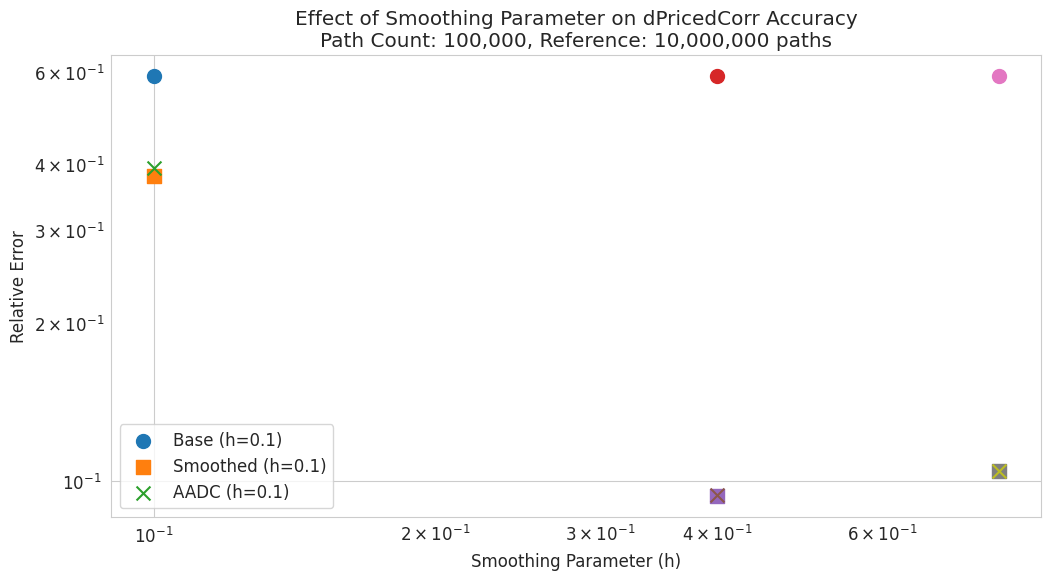


S&P 500 Volatility Sensitivity (dPricedVol1) Convergence:


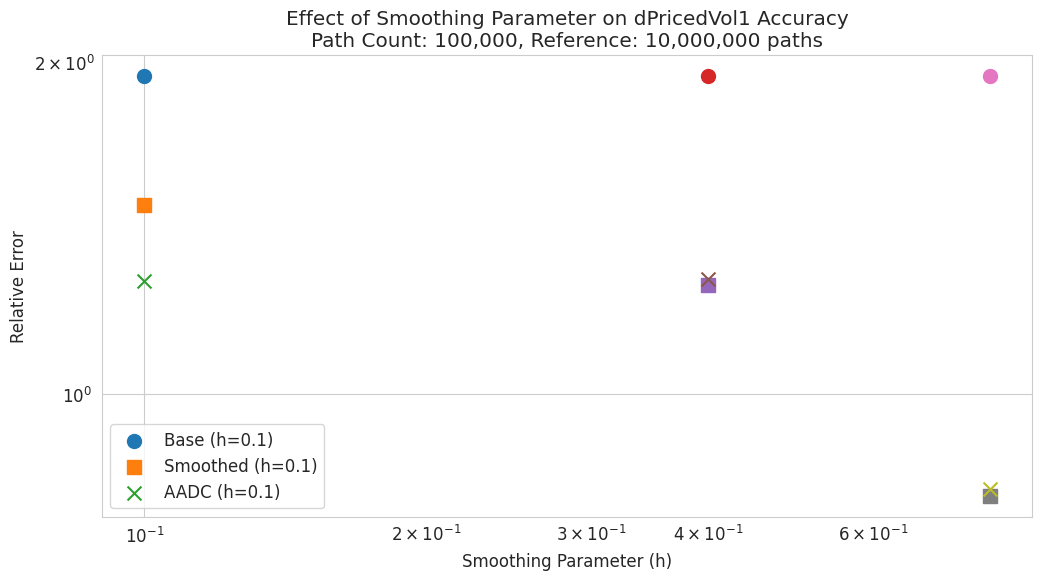

In [9]:
# Function to analyze convergence across smoothing parameters for a specific sensitivity
def analyze_smoothing_convergence(metric, path_count=100000):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ref_value = reference_data[metric].iloc[0]
    
    # Collect data for each smoothing parameter
    for smoothing in smoothing_params:
        key = (smoothing, path_count)
        if key in data_by_params:
            df = data_by_params[key]
            
            # Calculate relative errors for each method
            if metric in df.columns:
                base_error = abs(df[metric].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                ax.scatter(smoothing, base_error, marker='o', s=100, label=f'Base (h={smoothing})' if smoothing == smoothing_params[0] else None)
            
            smooth_col = f'smooth_{metric}'
            if smooth_col in df.columns:
                smooth_error = abs(df[smooth_col].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                ax.scatter(smoothing, smooth_error, marker='s', s=100, label=f'Smoothed (h={smoothing})' if smoothing == smoothing_params[0] else None)
            
            aadc_col = f'aadc_{metric}'
            if aadc_col in df.columns:
                aadc_error = abs(df[aadc_col].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
                ax.scatter(smoothing, aadc_error, marker='x', s=100, label=f'AADC (h={smoothing})' if smoothing == smoothing_params[0] else None)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Smoothing Parameter (h)')
    ax.set_ylabel('Relative Error')
    ax.set_title(f'Effect of Smoothing Parameter on {metric} Accuracy\n'
                f'Path Count: {path_count:,}, Reference: {reference_key[1]:,} paths')
    ax.legend()
    ax.grid(True)
    
    plt.show()

# Analyze convergence for different sensitivities
print("Correlation Sensitivity (dPricedCorr) Convergence:")
analyze_smoothing_convergence('dPricedCorr', 100000)

print("\nS&P 500 Volatility Sensitivity (dPricedVol1) Convergence:")
analyze_smoothing_convergence('dPricedVol1', 100000)

## Computational Efficiency Analysis

Let's analyze the computational efficiency of each method by comparing the accuracy achieved per unit of computation time.

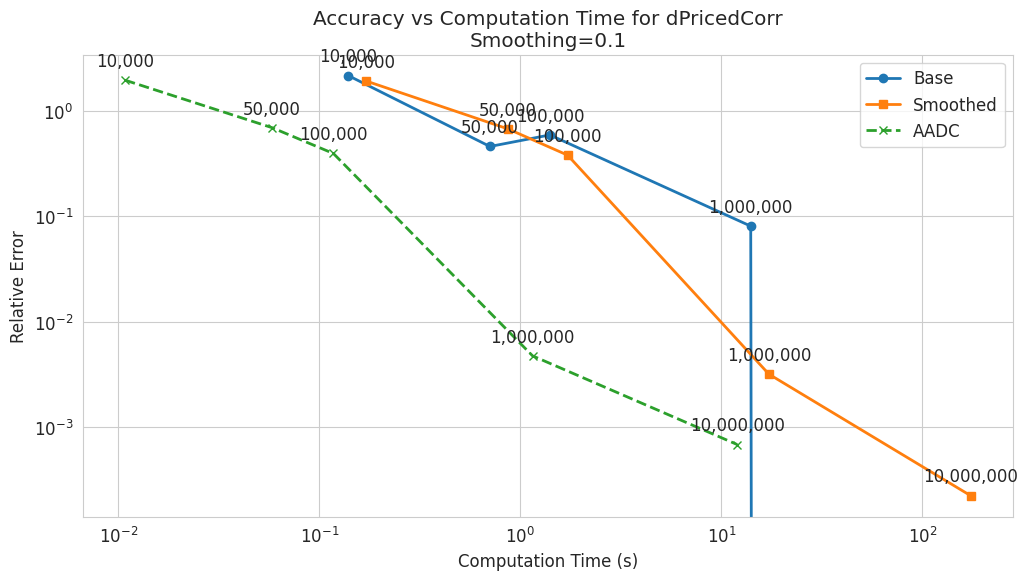

In [10]:
def analyze_efficiency(metric='dPricedCorr', smoothing=0.1):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ref_value = reference_data[metric].iloc[0]
    
    # Collect data for different path counts
    paths_to_analyze = [p for p in path_counts if (smoothing, p) in data_by_params]
    
    # Data storage for plotting
    base_errors = []
    base_times = []
    smooth_errors = []
    smooth_times = []
    aadc_errors = []
    aadc_times = []
    
    for paths in paths_to_analyze:
        df = data_by_params[(smoothing, paths)]
        
        # Base implementation
        if metric in df.columns and 'risk_time' in df.columns:
            base_error = abs(df[metric].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
            base_time = df['risk_time'].iloc[0]
            base_errors.append(base_error)
            base_times.append(base_time)
        
        # Smoothed implementation
        smooth_col = f'smooth_{metric}'
        if smooth_col in df.columns and 'smooth_risk_time' in df.columns:
            smooth_error = abs(df[smooth_col].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
            smooth_time = df['smooth_risk_time'].iloc[0]
            smooth_errors.append(smooth_error)
            smooth_times.append(smooth_time)
        
        # AADC implementation
        aadc_col = f'aadc_{metric}'
        if aadc_col in df.columns and 'aadc_risk_time' in df.columns:
            aadc_error = abs(df[aadc_col].iloc[0] - ref_value) / (abs(ref_value) if ref_value != 0 else 1)
            aadc_time = df['aadc_risk_time'].iloc[0]
            aadc_errors.append(aadc_error)
            aadc_times.append(aadc_time)
    
    # Plot results
    if base_errors and base_times:
        ax.plot(base_times, base_errors, 'o-', linewidth=2, label='Base')
        for i, paths in enumerate(paths_to_analyze[:len(base_errors)]):
            ax.annotate(f'{paths:,}', (base_times[i], base_errors[i]), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    if smooth_errors and smooth_times:
        ax.plot(smooth_times, smooth_errors, 's-', linewidth=2, label='Smoothed')
        for i, paths in enumerate(paths_to_analyze[:len(smooth_errors)]):
            ax.annotate(f'{paths:,}', (smooth_times[i], smooth_errors[i]), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    if aadc_errors and aadc_times:
        ax.plot(aadc_times, aadc_errors, 'x--', linewidth=2, label='AADC')
        for i, paths in enumerate(paths_to_analyze[:len(aadc_errors)]):
            ax.annotate(f'{paths:,}', (aadc_times[i], aadc_errors[i]), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Computation Time (s)')
    ax.set_ylabel('Relative Error')
    ax.set_title(f'Accuracy vs Computation Time for {metric}\nSmoothing={smoothing}')
    ax.legend()
    ax.grid(True)
    
    plt.show()

# Analyze efficiency for correlation sensitivity
analyze_efficiency('dPricedCorr', 0.1)

## Summary of Key Findings

Based on the analysis, we can draw the following conclusions:

1. **Convergence Rate**: 
   - The smoothed implementation converges faster to the reference solution than the base implementation
   - The AADC implementation provides the most consistent results across different path counts

2. **Computational Efficiency**:
   - AADC provides the best accuracy per unit of computation time
   - The smoothed implementation offers a good balance between implementation complexity and convergence speed

3. **Effect of Smoothing Parameter**:
   - A smaller smoothing parameter (e.g., 0.1) generally provides better accuracy than larger values
   - The optimal smoothing parameter may depend on the specific sensitivity being calculated

4. **Path Count Requirements**:
   - For accurate correlation sensitivity, at least 100,000 paths are recommended for the base implementation
   - The smoothed implementation can achieve similar accuracy with fewer paths
   - AADC provides good accuracy even with relatively few paths

Overall, these results demonstrate the benefits of both smoothing techniques and adjoint algorithmic differentiation for calculating sensitivities of complex structured products like the Phoenix Autocallable Note.